In [1]:
# Upload google drive in our COLAB
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
#Download HSI Data
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

URL transformed to HTTPS due to an HSTS policy
--2023-03-17 16:20:43--  https://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat.1’

PaviaU.mat.1        100%[===================>]  33.19M   185KB/s    in 2m 46s  

2023-03-17 16:23:30 (204 KB/s) - ‘PaviaU.mat.1’ saved [34806917/34806917]

URL transformed to HTTPS due to an HSTS policy
--2023-03-17 16:23:30--  https://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat.1’

PaviaU_gt.mat.1     100%[===================>]  10.75K  --.-KB/s    in 0s      

2023-03-17 16:23:31 (89.1 MB/s) - ‘PaviaU_gt.mat.1’ saved [11005/11005]

FINISHED --2023-03-17 16:23:

# Import Modules

In [40]:
# Importing librar 
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from keras.models import Sequential, Model
from sklearn.svm import SVC    
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import (accuracy_score,confusion_matrix, classification_report)
from tensorflow.keras.models import load_model, Sequential
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tqdm import tqdm
from time import time
from keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from keras.utils import to_categorical
from numpy.random import seed
seed(11)

## Read Data

In [41]:
# Load hyperspectral data and ground_truth
data =loadmat('PaviaU.mat')['paviaU']
gt=loadmat('PaviaU_gt.mat')['paviaU_gt']
print(f'Data Shape: {data.shape[:-1]}\nNumber of Bands: {data.shape[-1]}')

Data Shape: (610, 340)
Number of Bands: 103


# Visualize Data

Bands

In [42]:
df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))
df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]
df['class'] = gt.ravel()

In [ ]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,...,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,...,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,...,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,...,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,...,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


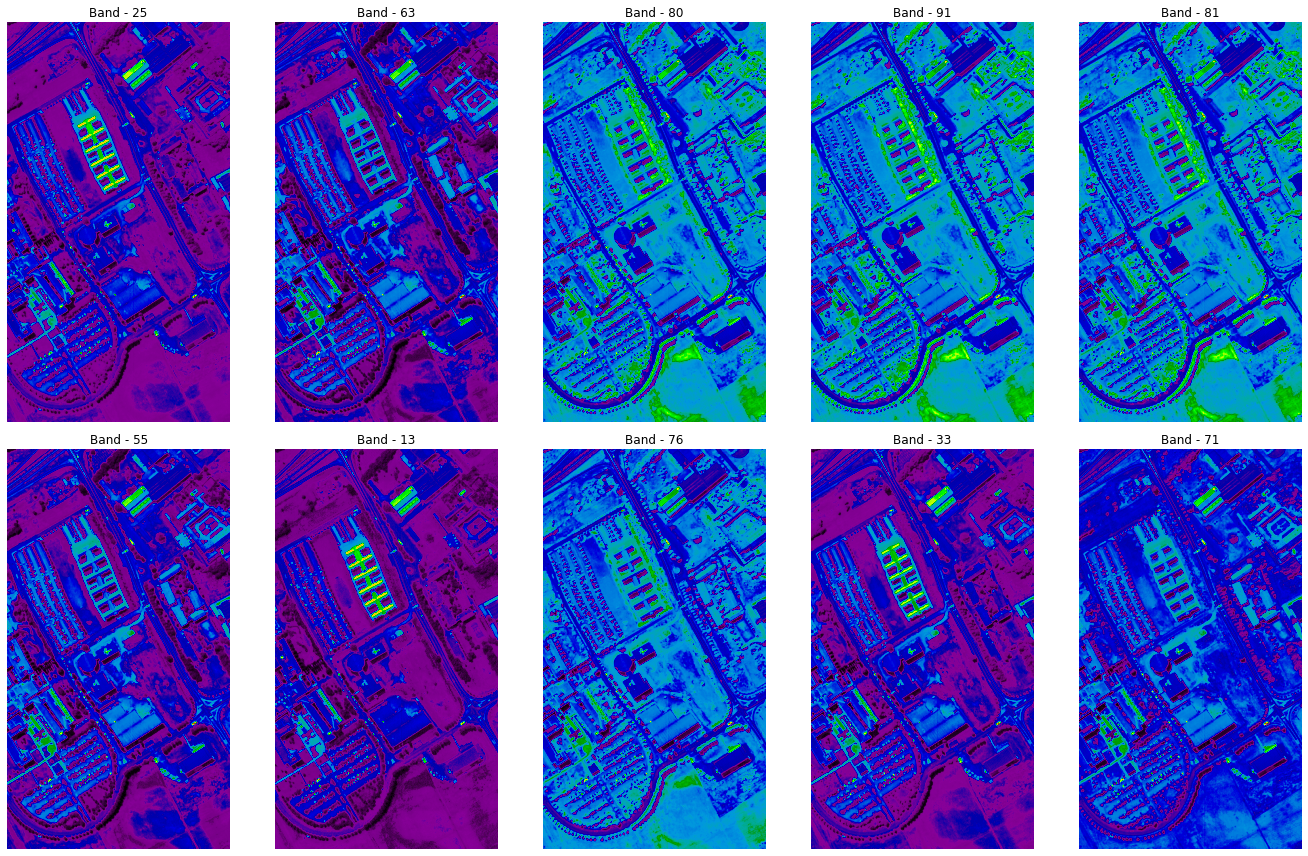

In [43]:
fig = plt.figure(figsize = (19, 12))
ax = fig.subplots(2, 5)
for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='nipy_spectral')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1
plt.tight_layout()
plt.show()

# RGB Composite Image

In [44]:
def plot_band(data):
    plt.figure(figsize=(10, 10))
    band_no = np.random.randint(data.shape[2])
    plt.imshow(data[:,:, band_no], cmap='viridis')
    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()

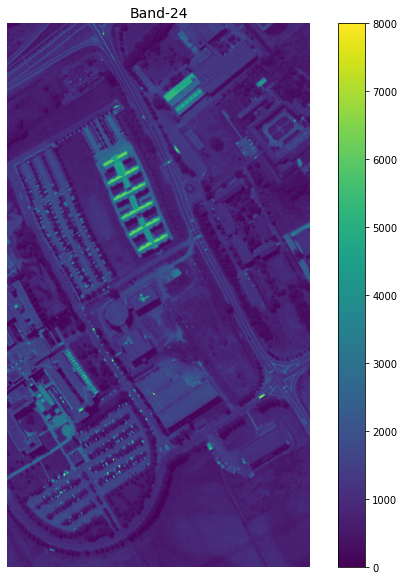

In [ ]:
plot_band(data)

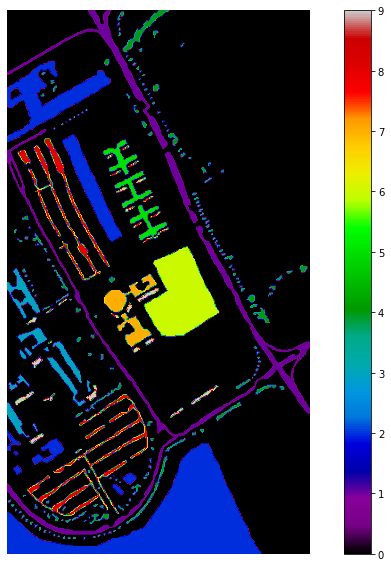

In [45]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
plot_data(gt)

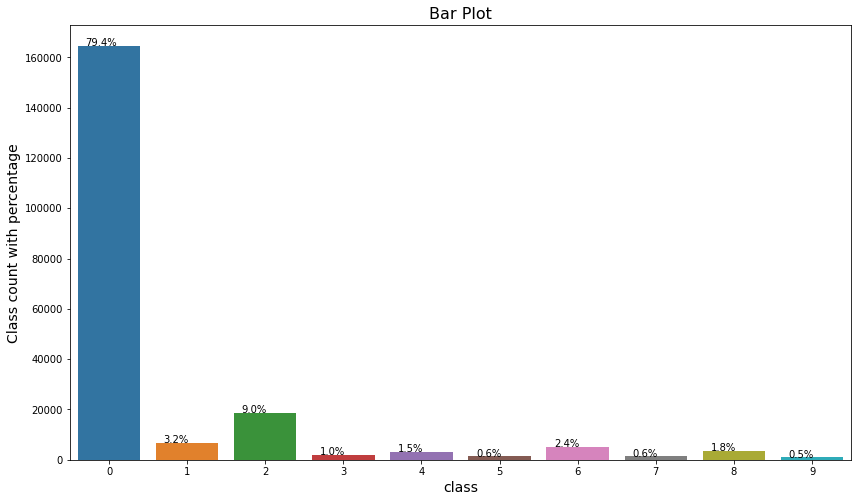

In [46]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(x='class', data=df[['class']])
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))
plt.ylabel('Class count with percentage', fontsize=14)
plt.xlabel('class', fontsize=14)
plt.title('Bar Plot', fontsize=16)
plt.show()

# Preprocessing

In [53]:
t_df = df[df['class']!=0]
ind = ['band'+str(i) for i in range(1, t_df.shape[-1])]
X = t_df.loc[:, ind]
y = to_categorical(t_df.loc[:, 'class'])
X_scaled = minmax_scale(X, axis = 0);
X_scaled.shape, y.shape

((42776, 103), (42776, 10))

# Train Test Split

In [54]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    stratify=y, 
                                                    test_size=0.30)
print(f"X_train: {x_train.shape}\ny_train: {y_train.shape}\nX_test: {x_test.shape}\ny_test: {y_test.shape}") 


X_train: (29943, 103)
y_train: (29943, 10)
X_test: (12833, 103)
y_test: (12833, 10)


# Model and Training

In [55]:
ip_shape = x_train[1].shape
n_outputs = y_train.shape[1]
x_train[1].ravel().shape

(103,)

In [56]:
x_train = x_train.reshape(-1,103, 1)
x_test = x_test.reshape(-1, 103, 1)

# Model_define

In [57]:
# convolutional layers
model = Sequential(name = 'CNN')
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model.add(Conv1D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
model.add(Dropout(0.4, name = 'Dropout1'))

model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
model.add(Dropout(0.4, name = 'Dropout2'))

model.add(Flatten(name = 'Flatten'))
model.add(Dense(25, activation='relu', name = 'DenseLayer'))
model.add(Dense(n_outputs, activation='softmax', name = 'OutputLayer'))

In [58]:
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv1D)             (None, 101, 64)           256       
                                                                 
 Layer2 (Conv1D)             (None, 99, 64)            12352     
                                                                 
 Layer3 (Conv1D)             (None, 97, 64)            12352     
                                                                 
 MaxPooling_Layer1 (MaxPooli  (None, 48, 64)           0         
 ng1D)                                                           
                                                                 
 Dropout1 (Dropout)          (None, 48, 64)            0         
                                                                 
 Layer4 (Conv1D)             (None, 46, 32)            6176      
                                                               

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
early_stop = EarlyStopping(monitor = 'val_loss',
                            mode = 'min',
                            min_delta = 0,
                            patience = 10,
                            restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'Salinas_Model.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True)

tensorboard = TensorBoard(log_dir='SA_logs/{}'.format(time()))

In [61]:
# train the network
hist =model.fit(x_train,y_train, epochs =49, batch_size = 32,validation_data = (x_test, y_test), callbacks=[early_stop,checkpoint,tensorboard])
loss, acc = model.evaluate(x_test, y_test, batch_size=32)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/49
936/936 [==============================] - 47s 47ms/step - loss: 0.7609 - accuracy: 0.7144 - val_loss: 0.5195 - val_accuracy: 0.7824
Epoch 2/49
936/936 [==============================] - 42s 45ms/step - loss: 0.5498 - accuracy: 0.7726 - val_loss: 0.4939 - val_accuracy: 0.7917
Epoch 3/49
936/936 [==============================] - 43s 46ms/step - loss: 0.5121 - accuracy: 0.7883 - val_loss: 0.4495 - val_accuracy: 0.8053
Epoch 4/49
936/936 [==============================] - 39s 42ms/step - loss: 0.4914 - accuracy: 0.7961 - val_loss: 0.4488 - val_accuracy: 0.8078
Epoch 5/49
936/936 [==============================] - 40s 43ms/step - loss: 0.4772 - accuracy: 0.8025 - val_loss: 0.4344 - val_accuracy: 0.8165
Epoch 6/49
936/936 [==============================] - 43s 46ms/step - loss: 0.4665 - accuracy: 0.8073 - val_loss: 0.4248 - val_accuracy: 0.8290
Epoch 7/49
936/936 [==============================] - 39s 42ms/step - loss: 0.4554 - accuracy: 0.8131 - val_loss: 0.3965 - val_accuracy:

In [62]:
print(f"Accuracy: {acc*100}\nLoss: {loss}")

Accuracy: 92.50370264053345
Loss: 0.20502203702926636


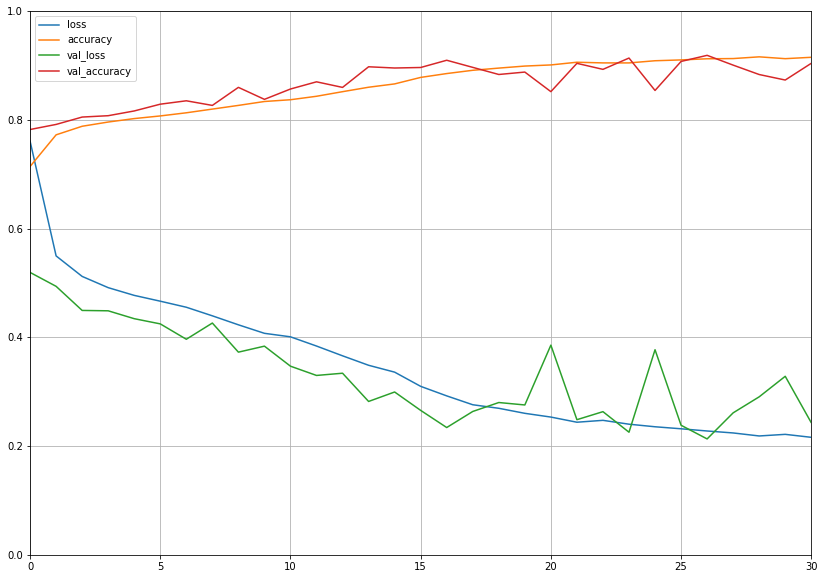

In [66]:
def plot_learning_curves(hist,epoch,min_val,max_val):
        pd.DataFrame(hist.history).plot(figsize=(14,10))
        plt.grid(True)
        plt.axis([0, epoch, min_val, max_val])
        plt.show()
plot_learning_curves(hist,30,0,1)

# Support Vector Machine (SVM)

In [70]:
# Extract features from the trained CNN model
feature_extractor = Sequential(model.layers[:-1])
# Extract features from the training and test sets
x_train_features = feature_extractor.predict(x_train)
x_test_features = feature_extractor.predict(x_test)
# Train an SVM classifier on the extracted features
svm = SVC(kernel='linear')
svm.fit(x_train_features, np.argmax(y_train, axis=1))
# Evaluate the SVM classifier on the test set
svm_score = svm.score(x_test_features, np.argmax(y_test, axis=1))
print("SVM accuracy:", svm_score)

402/402 [==============================] - 4s 10ms/step
SVM accuracy: 0.9506740434816489


# Validation

In [71]:
# Predict labels for the test set
y_pred = svm.predict(x_test_features)
# Convert one-hot encoded labels to integers
y_test = np.argmax(y_test, axis=1)
# Compute classification report
print('Classification report:\n', classification_report(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           1       0.96      0.96      0.96      1989
           2       0.97      0.98      0.97      5595
           3       0.87      0.81      0.84       630
           4       0.96      0.95      0.96       919
           5       1.00      1.00      1.00       403
           6       0.93      0.92      0.92      1509
           7       0.94      0.89      0.92       399
           8       0.87      0.91      0.89      1105
           9       1.00      1.00      1.00       284

    accuracy                           0.95     12833
   macro avg       0.95      0.94      0.94     12833
weighted avg       0.95      0.95      0.95     12833



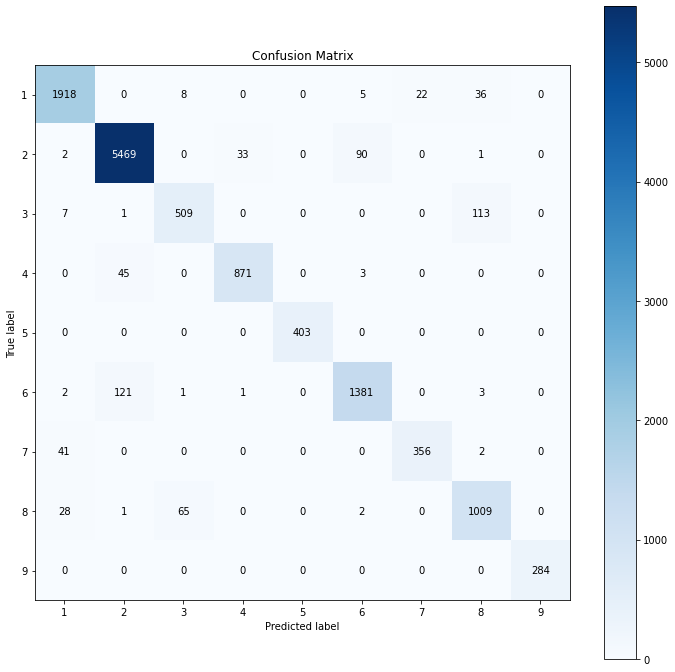

In [72]:
! pip install -q scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

In [73]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



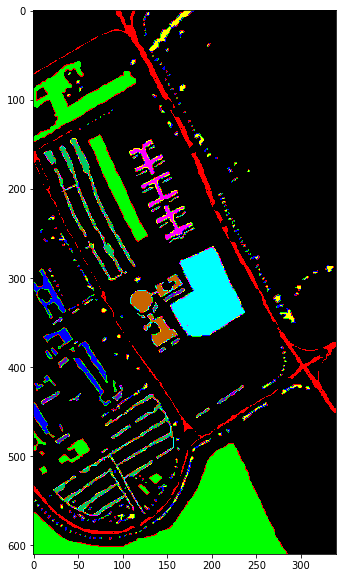

In [74]:
import spectral
# Plot the Predicted image
predict_image = spectral.imshow(classes = gt.astype(int),figsize =(12,10))